In [1]:
import math
import matplotlib.pyplot as plt
import torch

from azula.sample import LMSSampler
from einops import rearrange
from functools import partial
from omegaconf import OmegaConf
from pathlib import Path

from lpdm.data import field_preprocess, get_well_multi_dataset, isotropic_power_spectrum
from lpdm.diffusion import MaskedDenoiser, get_autoencoder, get_denoiser
from lpdm.plot import animate_fields

plt.rcParams["animation.ffmpeg_path"] = "/mnt/sw/nix/store/fz8y69w4c97lcgv1wwk03bd4yh4zank7-ffmpeg-full-6.0-bin/bin/ffmpeg"  # fmt: off
plt.rcParams["animation.html"] = "html5"

_ = torch.manual_seed(0)

/mnt/home/frozet/mpp-ldm/lpdm/nn/attention.py:9: FutureWarning: xformers.components is deprecated and is not maintained anymore. It might be removed in a future version of xFormers 
  import xformers.components.attention.core as xfa


In [2]:
runpath = Path("/mnt/ceph/users/frozet/mpp-ldm/runs/tn3g9rra_dit_large_soap_1e-05_0.0_cosine_1")  # fmt: off
cfg = OmegaConf.load(runpath / "config.yaml")
device = "cuda"

## Data

In [3]:
rollout_length = 64 // cfg.trajectory.stride + 1

testset = get_well_multi_dataset(
    path="/mnt/ceph/users/polymathic/the_well/datasets",
    physics=cfg.dataset.physics,
    split="test",
    steps=rollout_length,
    min_dt_stride=cfg.trajectory.stride,
    max_dt_stride=cfg.trajectory.stride,
    include_filters=cfg.dataset.include_filters,
)

preprocess = partial(
    field_preprocess,
    mean=torch.as_tensor(cfg.dataset.stats.mean, device=device),
    std=torch.as_tensor(cfg.dataset.stats.std, device=device),
    transform=cfg.dataset.transform,
)

## Autoencoder

In [4]:
autoencoder = get_autoencoder(
    pix_channels=testset.metadata.n_fields,
    **cfg.ae,
)

state = torch.load(runpath / "autoencoder/state.pth", weights_only=True)

if "predictor" in state:
    autoencoder.load_state_dict(state["autoencoder"])
else:
    autoencoder.load_state_dict(state)

autoencoder.cuda()
autoencoder.eval()

AutoEncoder(
  (encoder): Encoder(
    (descent): ModuleList(
      (0): ModuleList(
        (0): Conv2d(5, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ResBlock(
          (attn): Identity()
          (block): Sequential(
            (0): LayerNorm(dim=-3)
            (1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (2): SiLU()
            (3): Identity()
            (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
        )
      )
      (1): ModuleList(
        (0): Sequential(
          (0): Patchify()
          (1): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (1-2): 2 x ResBlock(
          (attn): Identity()
          (block): Sequential(
            (0): LayerNorm(dim=-3)
            (1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (2): SiLU()
            (3): Identity()
            (4): Conv2d(128, 128, kernel_si

## Denoiser

In [5]:
if "f8" in cfg.ae.name:
    shape = (cfg.ae.lat_channels, cfg.trajectory.length, 64, 64)
elif "f32" in cfg.ae.name:
    shape = (cfg.ae.lat_channels, cfg.trajectory.length, 16, 16)

denoiser = get_denoiser(
    shape=shape,
    label_features=testset.metadata.n_constant_scalars + 2 * testset.metadata.n_spatial_dims,
    **cfg.denoiser,
)

denoiser.load_state_dict(torch.load(runpath / "state.pth", weights_only=True))
denoiser.cuda()
denoiser.eval()

PreconditionedDenoiser(
  (backbone): FlattenWrapper(
    (wrappee): EmbeddingWrapper(
      (backbone): DiT(
        (patch): Rearrange('... C (L l) (H h) (W w) -> ... L H W (C l h w)', l=1, h=1, w=1)
        (unpatch): Rearrange('... L H W (C l h w) -> ... C (L l) (H h) (W w)', l=1, h=1, w=1)
        (in_proj): Linear(in_features=64, out_features=1024, bias=True)
        (out_proj): Linear(in_features=1024, out_features=64, bias=True)
        (positional_embedding): Sequential(
          (0): Linear(in_features=3, out_features=1024, bias=True)
          (1): SiLU()
          (2): Linear(in_features=1024, out_features=1024, bias=True)
        )
        (blocks): ModuleList(
          (0-15): 16 x DiTBlock(
            (norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=False)
            (ada_zero): Sequential(
              (0): Linear(in_features=256, out_features=1024, bias=True)
              (1): SiLU()
              (2): Linear(in_features=1024, out_features=6144, bias=True

In [6]:
sum(p.numel() for p in denoiser.parameters())

307674944

## Generation

In [7]:
sampler = LMSSampler(denoiser, steps=64).to(device)

label = torch.tensor([1.22] + 4 * [2.0]).to(device)

z1 = sampler.init((1, math.prod(shape)))
z0 = sampler(z1, label=label)
z0 = z0.reshape(shape)

with torch.no_grad():
    x = autoencoder.decode(rearrange(z0, "C L H W -> L C H W"))

x = rearrange(x, "L C H W -> L H W C").cpu()

In [8]:
animation = animate_fields(x, fields=cfg.dataset.fields)
display(animation)
plt.close()

## Condition

In [9]:
item = testset[666]
x = item["input_fields"]
x = x.to(device)
x = preprocess(x)
x = rearrange(x, "L H W C -> L C H W")

label = torch.cat([
    item["constant_scalars"].flatten(),
    item["boundary_conditions"].flatten(),
]).to(device)

with torch.no_grad():
    z = rearrange(autoencoder.encode(x), "L C H W -> C L H W")

x = rearrange(x, "L C H W -> L H W C").cpu()

In [10]:
def infer(mask, y):
    z = torch.zeros(shape, dtype=y.dtype, device=y.device)
    z[mask] = y.flatten()

    cond_sampler = MaskedDenoiser(
        denoiser,
        y=z.flatten(),
        mask=mask.flatten(),
    )

    cond_sampler = LMSSampler(cond_sampler, steps=64).to(device)

    z1 = cond_sampler.init((1, math.prod(shape)))
    z0 = cond_sampler(z1, label=label)
    z0 = z0.reshape(shape)

    with torch.no_grad():
        x_hat = autoencoder.decode(rearrange(z0, "C L H W -> L C H W"))

    x_hat = rearrange(x_hat, "L C H W -> L H W C").cpu()

    return x_hat, z0

In [11]:
mask = torch.zeros(shape, dtype=bool)
mask[:, 0] = True

y = z[:, 0]

x_hat, z_hat = infer(mask, y)

In [12]:
animation = animate_fields(x[: cfg.trajectory.length], x_hat, fields=cfg.dataset.fields)
display(animation)
plt.close()

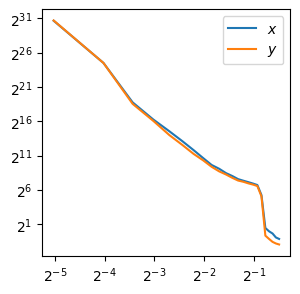

In [13]:
x_ps, x_edges = isotropic_power_spectrum(x[cfg.trajectory.length - 1, ..., 1], spatial=2)
y_ps, _ = isotropic_power_spectrum(x_hat[cfg.trajectory.length - 1, ..., 1], spatial=2)

plt.figure(figsize=(3.2, 3.2))
plt.loglog(x_edges[1:], x_ps, label="$x$", base=2)
plt.loglog(x_edges[1:], y_ps, label="$y$", base=2)
plt.legend()
plt.show()

## Rollout

In [14]:
mask = torch.zeros(shape, dtype=bool)
mask[:, 0] = True

y = z[:, 0]

trajectory = []

while len(trajectory) < rollout_length:
    x_hat, z_hat = infer(mask, y)

    if trajectory:
        trajectory.extend(x_hat[1:].unbind(0))
    else:
        trajectory.extend(x_hat.unbind(0))

    y = z_hat[:, -1]

x_hat = torch.stack(trajectory)

In [15]:
animation = animate_fields(x, x_hat, fields=cfg.dataset.fields)
display(animation)
plt.close()

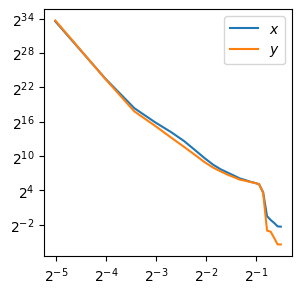

In [16]:
x_ps, x_edges = isotropic_power_spectrum(x[-1, ..., 1], spatial=2)
y_ps, _ = isotropic_power_spectrum(x_hat[-1, ..., 1], spatial=2)

plt.figure(figsize=(3.2, 3.2))
plt.loglog(x_edges[1:], x_ps, label="$x$", base=2)
plt.loglog(x_edges[1:], y_ps, label="$y$", base=2)
plt.legend()
plt.show()